### Analysis and plotting

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

%matplotlib inline

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
## Open data files

---
---
#### Open our merged GOES-CUES dataset

In [5]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

Load MODIS observations of the CUES site

In [6]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

When do we have ASTER observations of this site? (convert from UTC to UTC-8)

In [7]:
# Find all our ASTER files for the CUES site
directory1 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_Tuolumne_only/'
directory2 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_both/'

aster_files = getListOfFiles(directory1) + getListOfFiles(directory2)

## Parse the date and time from ASTER filenames
aster_datetimes = []
for fpath in aster_files:
    #fn = re.split('\/+|\\+',fpath)[-1] # re method
    fn = fpath.split('/')[-1] # non-re method
    MM = fn.split('_')[2][3:5]
    DD = fn.split('_')[2][5:7]
    YYYY = fn.split('_')[2][7:11]
    hh = fn.split('_')[2][11:13]
    mm = fn.split('_')[2][13:15]
    ss = fn.split('_')[2][15:17]
    aster_datetimes.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss)) - pd.Timedelta(hours=8))

aster = pd.DataFrame({'datetime': aster_datetimes, 'filepath': aster_files})
aster.sort_values('datetime',inplace=True)
aster.reset_index(inplace=True, drop=True)

Set font sizes for plots

In [8]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [9]:
def plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color='k', heatmap_cmap=None):
    _x = _x.sel(datetime=slice(startdate, enddate))
    _y = _y.sel(datetime=slice(startdate, enddate))

    # Linear regression between x and y
    x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar = quickstats(_x, _y)
    fit = slope*x + intercept
    # Compute some more stats between x and y:
    #print('r-squared = {}'.format(np.round(r_value**2,2)))

    
    plt.figure(figsize=(5.5,5.5))
    # Plot gridlines
    plt.grid(color='grey', linestyle=':', linewidth=1)
    # Plot points and best linear fit
    #plt.plot(x, fit, ':r', zorder=99)

    if heatmap_cmap == None:
        plt.plot(x,y,'.',color=point_color,markersize=5,alpha=0.5)
    else:
        # Create 2d histogram "heatmap"
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        # Plot "heatmap"
        plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=heatmap_cmap)
        plt.colorbar(label='number of records')

    # Plot 1-to-1 line
    plt.plot([-30,30],[-30,30],':k')

    # Set axes limits
    plt.xlim([-30,30])
    plt.ylim([-30,30])

    # Set axes labels, plot title
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title('{} -- {}\n$RMSE$ = {}, mean bias = {}'.format(startdate,enddate,
                                                            np.round(rmse,2),
                                                           np.round(mbe,2)))
    plt.tight_layout()
    
    return None

def quickstats(_x,_y):
    # remove nan values from input _x and _y before linear regression
    df1 = pd.DataFrame({'x': _x})
    df1['y'] = _y
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Linear regression between x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean(np.square(y - x)))
    
    # Mean Bias Error
    mbe = np.mean(y - x)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(y - x))
    
    # Covariance
    X = np.stack((x, y), axis=0)
    covar = np.cov(X)
    
    return x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar

In [10]:
from datetime import timedelta, datetime

def datetimerange(start_date, end_date, n_hours):
    # https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python/1060330#1060330
    # for every hour in this date range
    for n in range(int ( (end_date - start_date).total_seconds() / 3600 )):
        # if we've moved n_hours
        if n % n_hours == 0:
            # return the start date + that many hours we've stepped forward
            yield start_date + timedelta(hours=n)

---

# Compute Stats:

### GOES Tb vs snow

Compute statistics over a short time window (1-hour to daily) that describe how well GOES Tb matches ground-based measurements of Tss.

Here we are filtering to only look at snow surface temperature using:
* cloud flag = 0
* snow depth > 5 cm

In [11]:
df_snow = pd.read_pickle('goes-cues-2017-2020-6hr.pkl')

In [22]:
df_soil = pd.read_pickle('goes-cues-2017-2020-6hr_soil.pkl')

### for inspecting the entire time series

In [23]:
df = df_soil

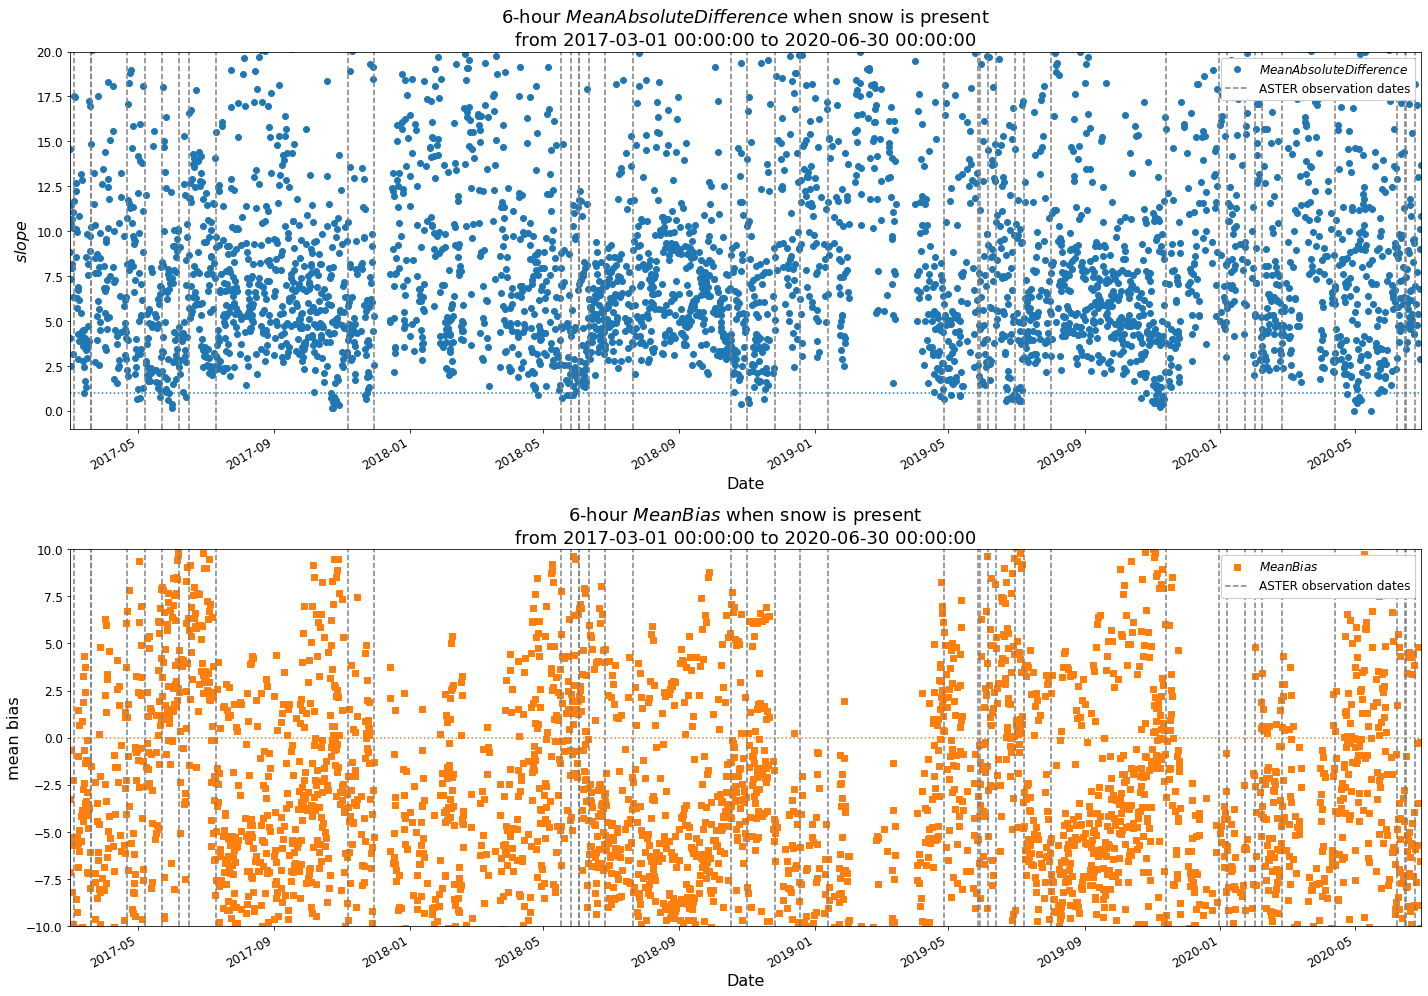

In [24]:
# Set start and end dates for time period we want to look at
startdate = pd.Timestamp('2017-03-01')
enddate = pd.Timestamp('2020-06-30')

# Set up figure
fig, ax = plt.subplots(2,1,figsize=(20,14))

df.rmse.plot(linestyle='none',marker='o',c='tab:blue',ax=ax[0], label='slope')
ax[0].axhline(y=1,linestyle=':',color='tab:blue')
ax[0].set_ylim([-1,20])
ax[0].set_ylabel('$slope$')

#ax2 = ax.twinx()
#df.rmse.plot(linestyle='-',marker='.',c='tab:orange',ax=ax2)
#df.mae.plot(linestyle='-',marker='.',c='tab:red',ax=ax2)
df.mbe.plot(linestyle='none',marker='s',c='tab:orange',ax=ax[1], label='mean bias')
ax[1].axhline(y=0,linestyle=':',color='tab:orange')
ax[1].set_ylim([-10,10])
ax[1].set_ylabel('mean bias')


ax[0].set_xlim([startdate,enddate])
ax[0].set_xlabel('Date')
ax[1].set_xlim([startdate,enddate])
ax[1].set_xlabel('Date')

# Plot when we have ASTER observations of the CUES site
for aster_datetime in aster.datetime:
    ax[0].axvline(x=aster_datetime, color='grey', linestyle='--')
    ax[1].axvline(x=aster_datetime, color='grey', linestyle='--')

# Set titles
ax[0].set_title('6-hour $Mean Absolute Difference$ when snow is present\nfrom {} to {}'.format(startdate,enddate));
ax[1].set_title('6-hour $Mean Bias$ when snow is present\nfrom {} to {}'.format(startdate,enddate));
# make legends
lines = [ax[0].lines[0], ax[0].lines[2]]
labels = ['$Mean Absolute Difference$', 'ASTER observation dates']
ax[0].legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)
lines = [ax[1].lines[0], ax[1].lines[2]]
labels = ['$Mean Bias$', 'ASTER observation dates']
ax[1].legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)

# Save figure image
plt.tight_layout()
#plt.savefig('goes-vs-cues-2017-2020.jpg',dip=300);

Boxplot customization

In [32]:
snow_boxprops = dict(linestyle='-', linewidth=1)
snow_flierprops = dict(marker='.', markerfacecolor='#bbbbbb', markeredgecolor='none', markersize=3,linestyle='none')
snow_medianprops = dict(linestyle='-', linewidth=1)
snow_meanpointprops = dict(marker='o', markeredgecolor='none',markerfacecolor='k')
snow_meanlineprops = dict(linestyle=':', linewidth=1, color='k')
snow_whiskerprops = dict(color='k', linewidth=1, linestyle='-')
snow_capprops = dict(color='k')

soil_boxprops = dict(linestyle='-', linewidth=1)
soil_flierprops = dict(marker='.', markerfacecolor='#bbbbbb', markeredgecolor='none', markersize=3,linestyle='none')
soil_medianprops = dict(linestyle='-', linewidth=1)
soil_meanpointprops = dict(marker='o', markeredgecolor='none',markerfacecolor='r')
soil_meanlineprops = dict(linestyle=':', linewidth=1, color='r')
soil_whiskerprops = dict(color='k', linewidth=1, linestyle='-')
soil_capprops = dict(color='k')

Select only summer/fall months for soil temp, winter/spring months for snow temp

In [128]:
df_soil_summer_fall = df_soil.loc[(df_soil.index.month >= 7) & \
                                  (df_soil.index.month <= 11)]

df_snow_winter_spring = df_snow.loc[((df_snow.index.month >= 1) & \
                                    (df_snow.index.month <= 6)) | \
                                    (df_snow.index.month == 12)]

### Mean Absolute Difference

by Month-Year

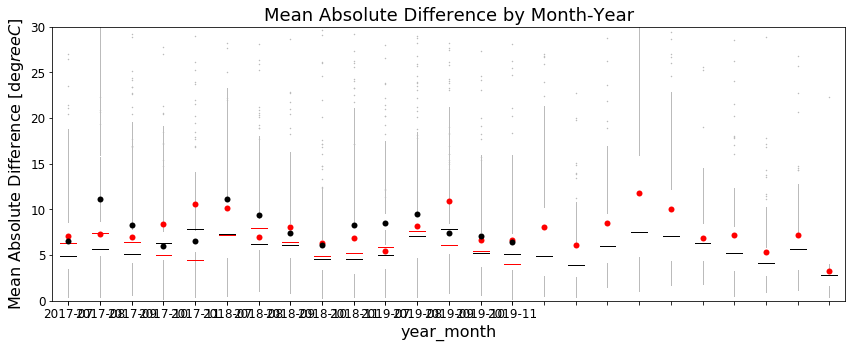

In [186]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5), sharex=True)



# Boxplots for snow vs GOES
boxplot = df_snow_winter_spring.boxplot(column='mae', by='year_month',
                          ax=ax,
                          backend='matplotlib',
                          grid=False,
                          meanline=False,
                          showbox=False,
                          showcaps=False,
                          showmeans=True,
                          color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                          boxprops=soil_boxprops,
                          whiskerprops=soil_whiskerprops,
                          capprops=soil_capprops,
                          flierprops=soil_flierprops,
                          medianprops=soil_medianprops,
                          meanprops=soil_meanpointprops)

# Boxplots for soil vs GOES
boxplot = df_soil_summer_fall.boxplot(column='mae', by='year_month',
                          ax=ax,
                          backend='matplotlib',
                          grid=False,
                          meanline=False,
                          showbox=False,
                          showcaps=False,
                          showmeans=True,
                          color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='r', caps='none'),
                          boxprops=snow_boxprops,
                          whiskerprops=snow_whiskerprops,
                          capprops=snow_capprops,
                          flierprops=snow_flierprops,
                          medianprops=snow_medianprops,
                          meanprops=snow_meanpointprops)


ax.set_title('Mean Absolute Difference by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
#plt.xticks(rotation=45, horizontalalignment='center');
plt.ylim(0,30);
ax.set_ylabel('Mean Absolute Difference [$\degreeC$]')



plt.tight_layout()
#plt.savefig('figures/mean-absolute-difference-monthly.jpg')

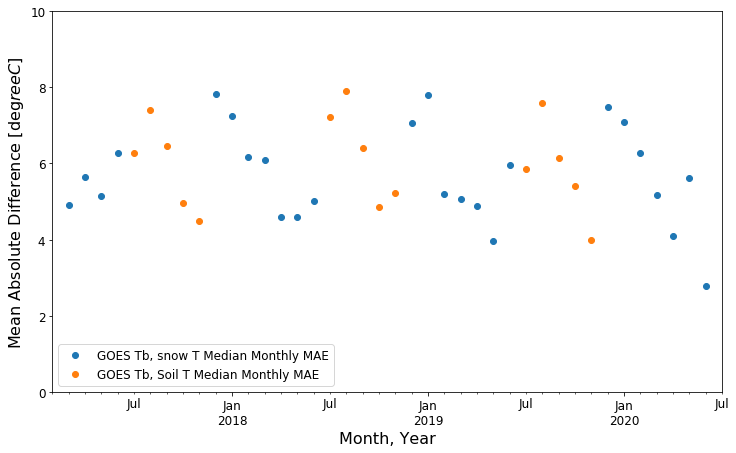

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7), sharex=True)

#df_snow_winter_spring.groupby('year_month')['mae'].mean().plot(ax=ax, color='tab:blue', linestyle='none', marker='.', label='GOES Tb, snow T Median Monthly MAE')
df_snow_winter_spring.groupby('year_month')['mae'].median().plot(ax=ax, color='tab:blue', linestyle='none', marker='o', label='GOES Tb, snow T Median Monthly MAE')

#df_soil_summer_fall.groupby('year_month')['mae'].mean().plot(ax=ax, color='tab:orange', linestyle='none', marker='.', label='GOES Tb, Soil T Median Monthly MAE')
df_soil_summer_fall.groupby('year_month')['mae'].median().plot(ax=ax, color='tab:orange', linestyle='none', marker='o', label='GOES Tb, Soil T Median Monthly MAE')

ax.set_ylim(0,10);
ax.set_xlim(pd.Timestamp('2017-02-01'),pd.Timestamp('2020-07-01'));
ax.set_ylabel('Mean Absolute Difference [$\degreeC$]')
ax.set_xlabel('Month, Year')

plt.legend(loc='lower left')

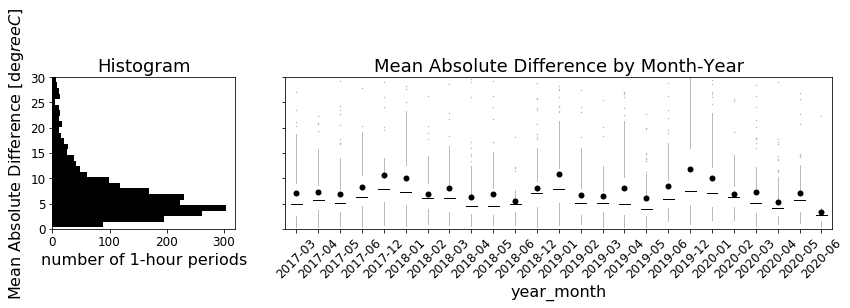

In [187]:
df = df_snow_winter_spring.copy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True, gridspec_kw={'width_ratios': [1, 3]})

# Boxplots
boxplot = df.boxplot(column='mae', by='year_month',
                     ax=ax[1],
                     backend='matplotlib',
                     grid=False,
                     meanline=False,
                     showbox=False,
                     showcaps=False,
                     showmeans=True,
                     color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                     boxprops=boxprops,
                     whiskerprops=whiskerprops,
                     capprops=capprops,
                     flierprops=flierprops,
                     medianprops=medianprops,
                     meanprops=meanpointprops)
ax[1].set_title('Mean Absolute Difference by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
plt.xticks(rotation=45, horizontalalignment='center');

# Histogram
ax[0].hist(df.mae,
           bins=int(np.sqrt(len(df.mae))),
           orientation='horizontal',
           color = '#000000',
           ec='none',
           lw=1)
ax[0].set_title('Histogram')
# Histogram x-axis formatting
ax[0].set_xlabel('number of 1-hour periods')

# Format shared y-axis
plt.ylim(0,30);
ax[0].set_ylabel('Mean Absolute Difference [$\degreeC$]')

plt.tight_layout()
#plt.savefig('figures/mean-absolute-difference-monthly.jpg')

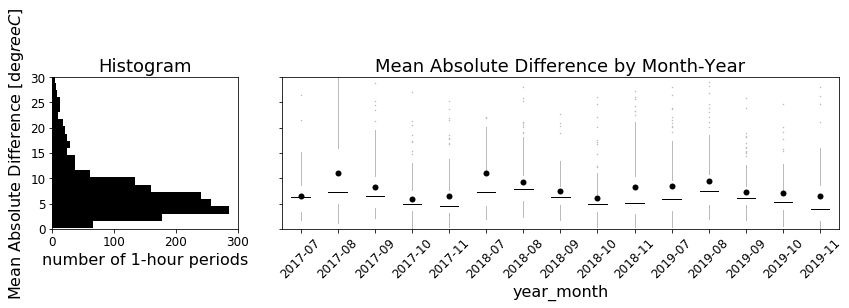

In [188]:
df = df_soil_summer_fall.copy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True, gridspec_kw={'width_ratios': [1, 3]})

# Boxplots
boxplot = df.boxplot(column='mae', by='year_month',
                     ax=ax[1],
                     backend='matplotlib',
                     grid=False,
                     meanline=False,
                     showbox=False,
                     showcaps=False,
                     showmeans=True,
                     color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                     boxprops=boxprops,
                     whiskerprops=whiskerprops,
                     capprops=capprops,
                     flierprops=flierprops,
                     medianprops=medianprops,
                     meanprops=meanpointprops)
ax[1].set_title('Mean Absolute Difference by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
plt.xticks(rotation=45, horizontalalignment='center');

# Histogram
ax[0].hist(df.mae,
           bins=int(np.sqrt(len(df.mae))),
           orientation='horizontal',
           color = '#000000',
           ec='none',
           lw=1)
ax[0].set_title('Histogram')
# Histogram x-axis formatting
ax[0].set_xlabel('number of 1-hour periods')

# Format shared y-axis
plt.ylim(0,30);
ax[0].set_ylabel('Mean Absolute Difference [$\degreeC$]')

plt.tight_layout()
#plt.savefig('figures/mean-absolute-difference-monthly.jpg')

by month for each year

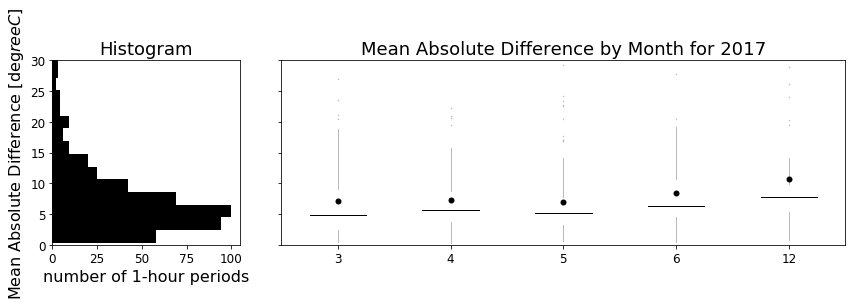

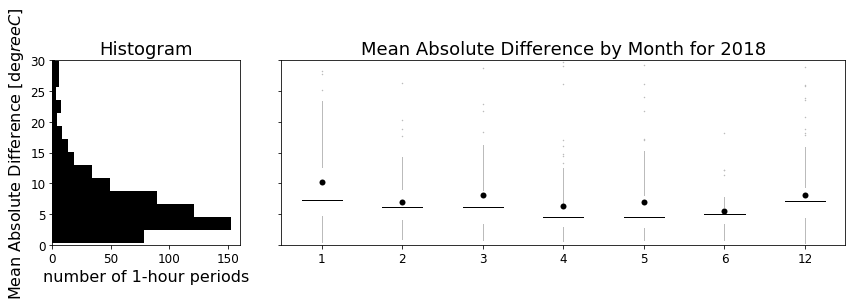

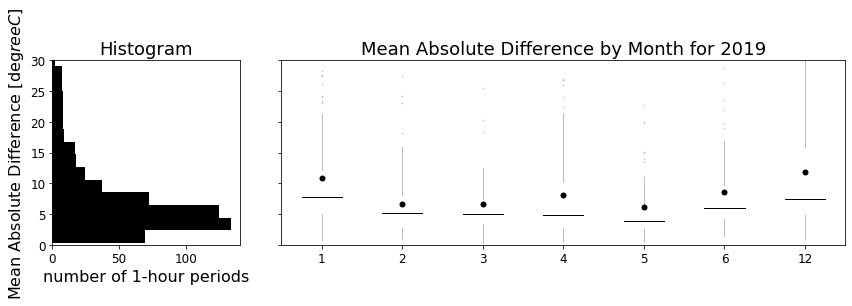

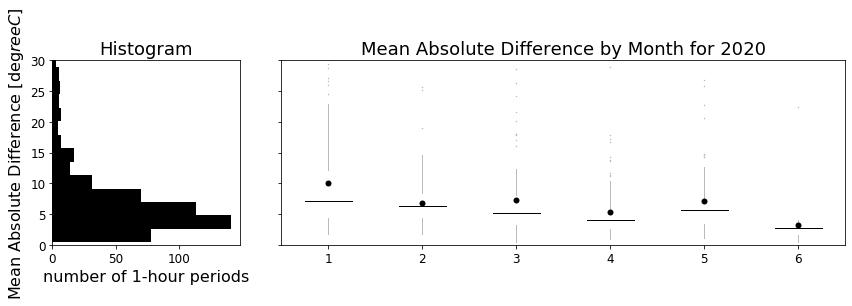

In [189]:
df = df_snow_winter_spring.copy()
for year in df.index.year.unique():
    
    mask = df.index.year==year
    df_n = df.loc[mask]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True, gridspec_kw={'width_ratios': [1, 3]})
    
    # Boxplots
    boxplot = df_n.boxplot(column='mae', by=df_n.index.month,
                         ax=ax[1],
                         backend='matplotlib',
                         grid=False,
                         meanline=False,
                         showbox=False,
                         showcaps=False,
                         showmeans=True,
                         color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                         boxprops=boxprops,
                         whiskerprops=whiskerprops,
                         capprops=capprops,
                         flierprops=flierprops,
                         medianprops=medianprops,
                         meanprops=meanpointprops)
    ax[1].set_title('Mean Absolute Difference by Month for {}'.format(year))
    plt.suptitle('') # this removes pandas' default title
    ax[1].set_xlabel('') # this removes pandas' default x labels
    # Boxplot x-axis formatting
    #plt.xticks(rotation=45, horizontalalignment='center');
    
    # Histogram
    ax[0].hist(df_n.mae,
               bins=int(np.sqrt(len(df_n.mae))),
               orientation='horizontal',
               color = '#000000',
               ec='none',
               lw=1)
    ax[0].set_title('Histogram')
    # Histogram x-axis formatting
    ax[0].set_xlabel('number of 1-hour periods')
    
    # Format shared y-axis
    plt.ylim(0,30);
    ax[0].set_ylabel('Mean Absolute Difference [$\degreeC$]')
    
    plt.tight_layout()
    plt.savefig('figures/mean-absolute-difference-monthly-{}.jpg'.format(year))

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

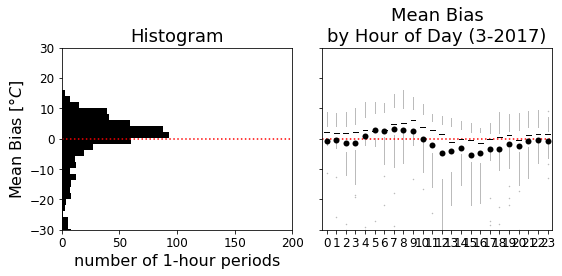

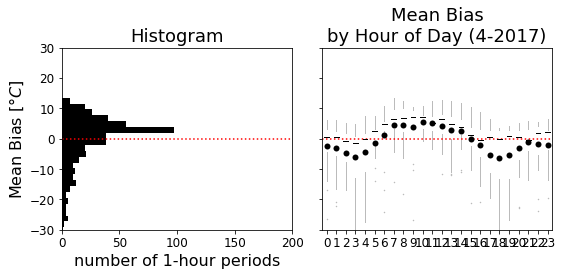

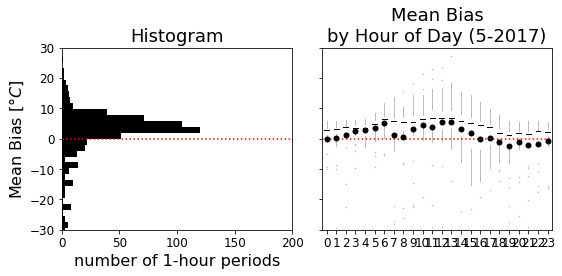

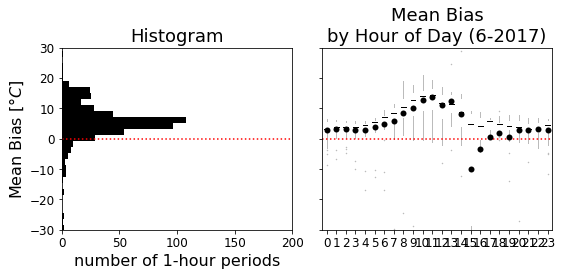

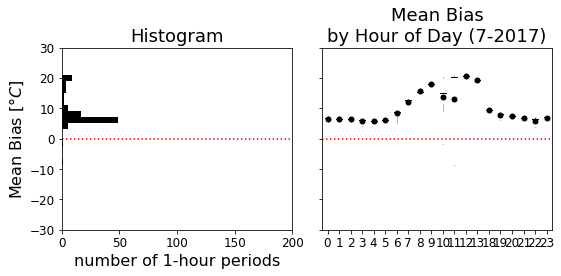

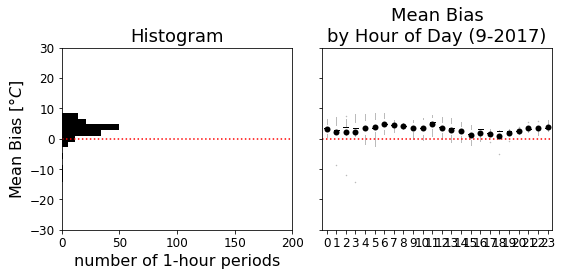

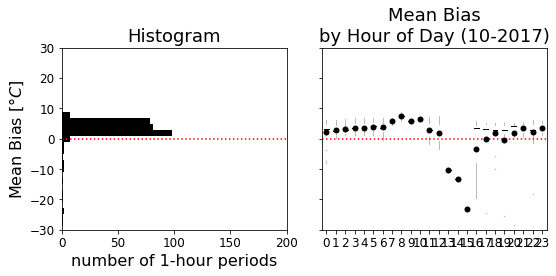

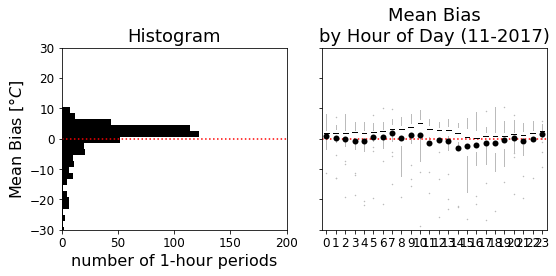

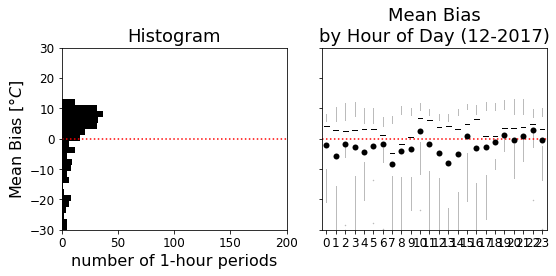

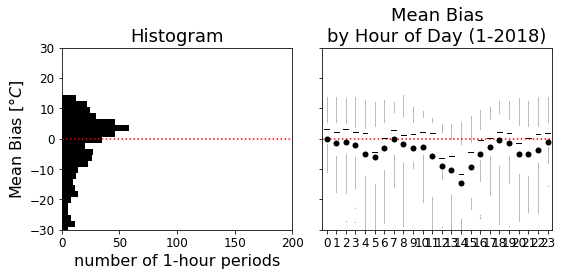

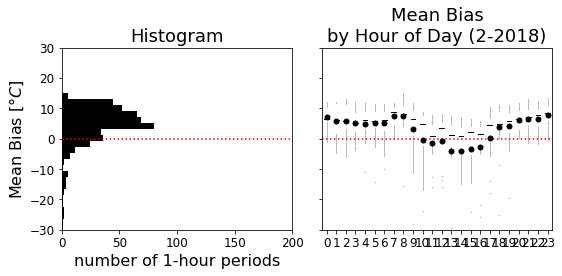

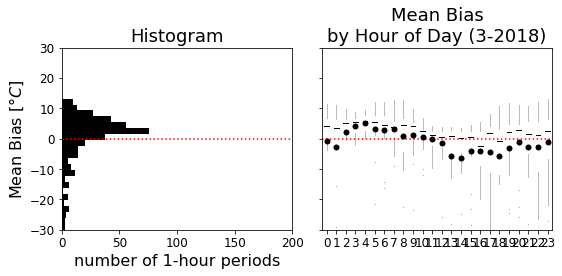

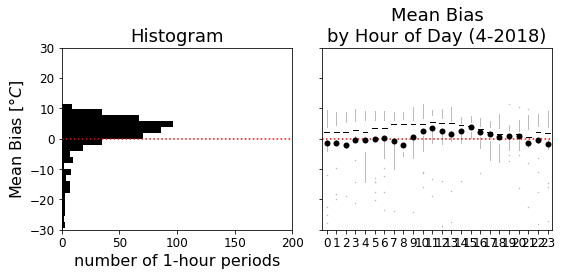

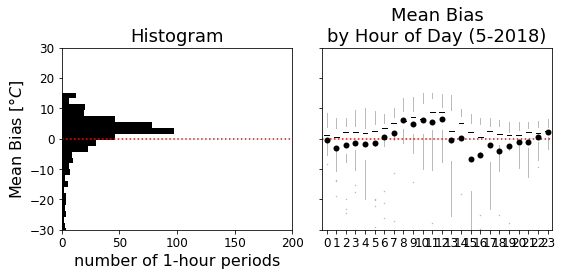

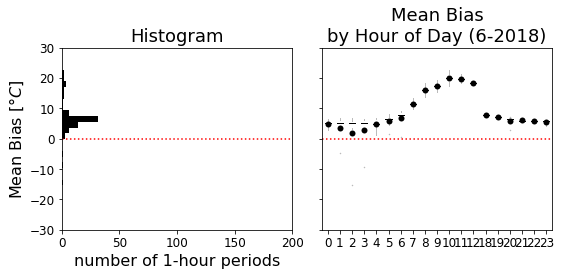

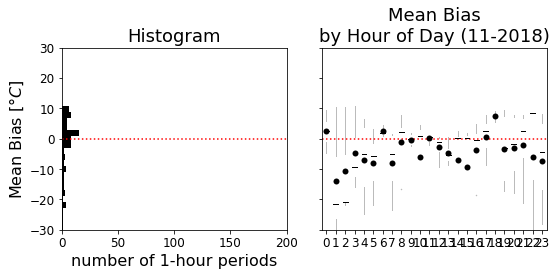

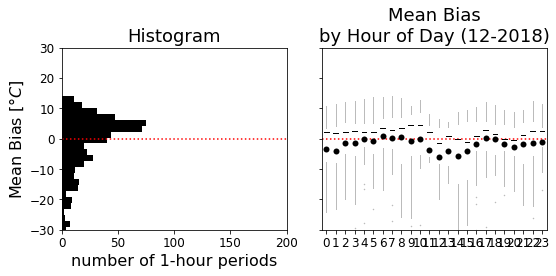

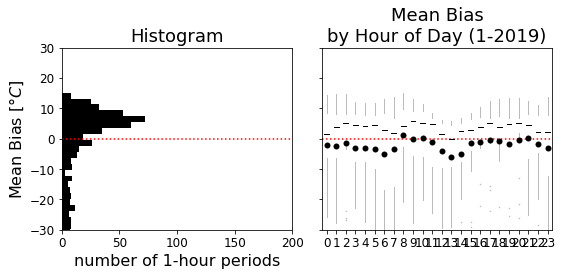

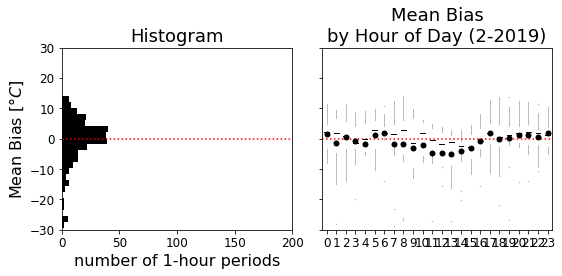

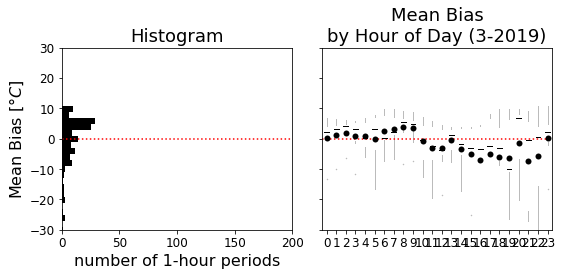

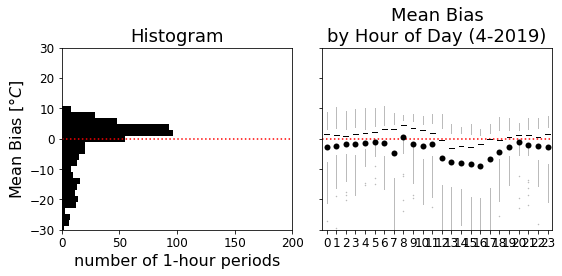

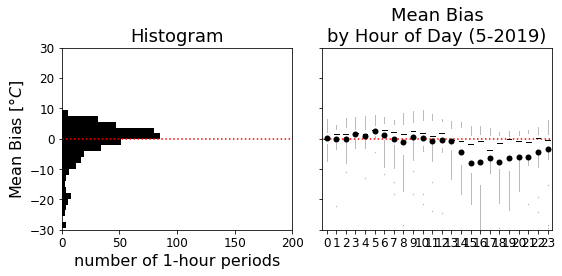

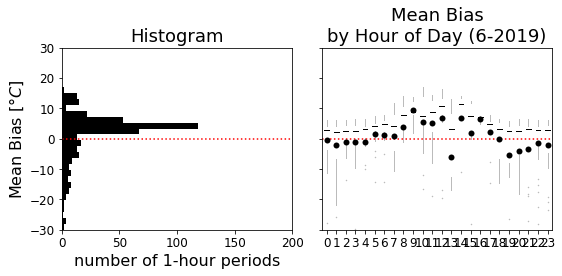

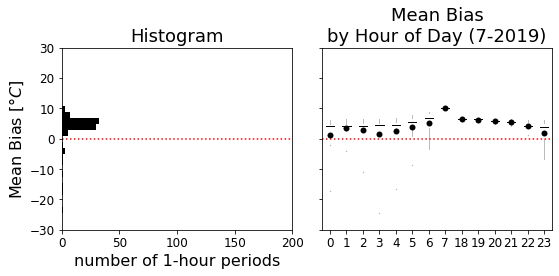

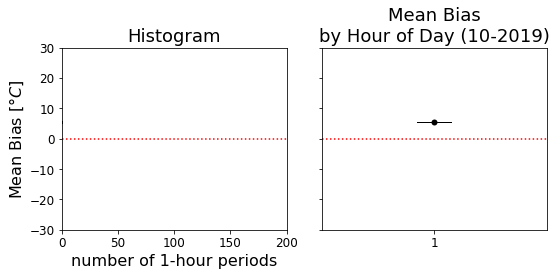

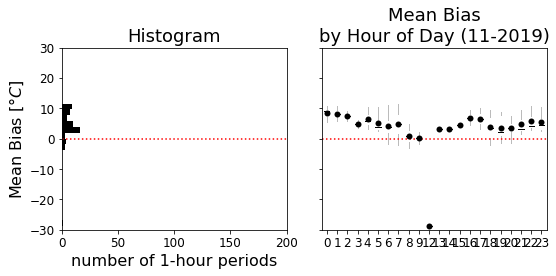

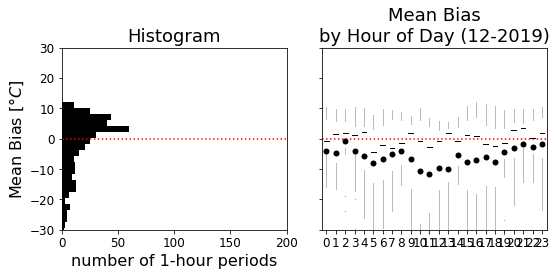

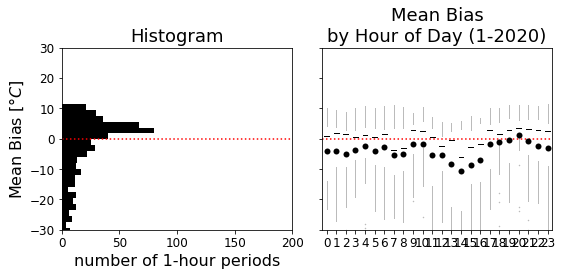

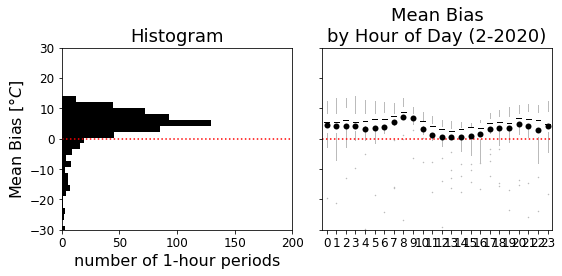

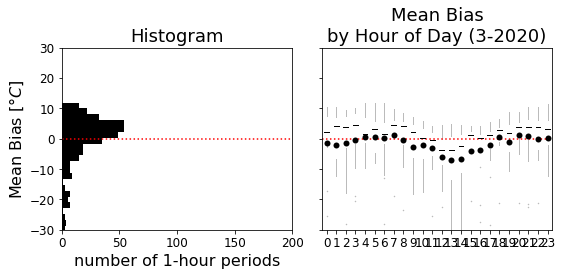

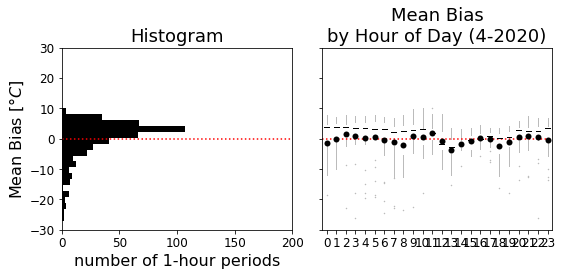

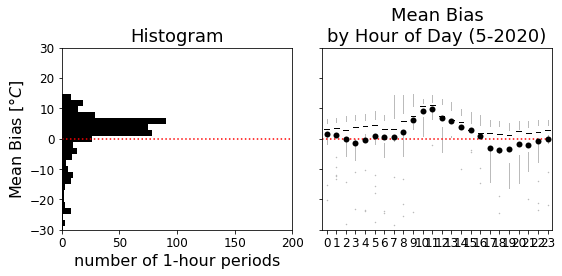

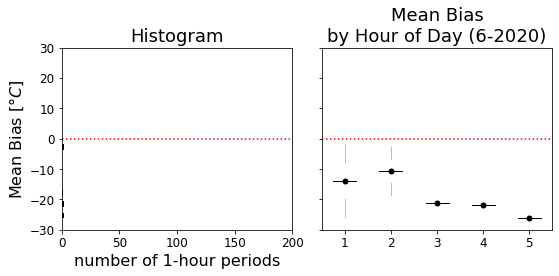

In [203]:
df = pd.read_pickle('goes-cues-2017-2020-1hr.pkl')
#df_snow_winter_spring.copy()

for year in df.index.year.unique():
    mask = df.index.year==year
    df_n = df.loc[mask]
    
    for month in df_n.index.month.unique():
        mask = df_n.index.month==month
        df_m = df_n.loc[mask]

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

        # MAE Boxplots
        boxplot = df_m.boxplot(column='mbe', by=df_m.index.hour,
                             ax=ax[1],
                             backend='matplotlib',
                             grid=False,
                             meanline=False,
                             showbox=False,
                             showcaps=False,
                             showmeans=True,
                             color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                             boxprops=boxprops,
                             whiskerprops=whiskerprops,
                             capprops=capprops,
                             flierprops=flierprops,
                             medianprops=medianprops,
                             meanprops=meanpointprops)
        ax[1].set_title('Mean Bias\nby Hour of Day ({}-{})'.format(month,year))
        plt.suptitle('') # this removes pandas' default title
        ax[1].set_xlabel('') # this removes pandas' default x labels
        # Boxplot x-axis formatting
        #plt.xticks(rotation=45, horizontalalignment='center');
        ax[1].axhline(0,linestyle=':',color='r')


        # MAE Histogram
        ax[0].hist(df_m.mbe,
                   bins=int((df_m.mbe.max() - df_m.mbe.min())/2)+1,
                   orientation='horizontal',
                   color = '#000000',
                   ec='none',
                   lw=1)
        ax[0].axhline(0,linestyle=':',color='r')
        ax[0].set_title('Histogram')
        # Histogram x-axis formatting
        ax[0].set_xlabel('number of 1-hour periods')
        ax[0].set_xlim(0,200)

        # Format shared y-axis
        plt.ylim(-30,30);
        ax[0].set_ylabel('Mean Bias [$\degree C$]')

        plt.tight_layout()
        plt.savefig('figures/mean-bias-hourly-{}-{}.jpg'.format(month,year))

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inte

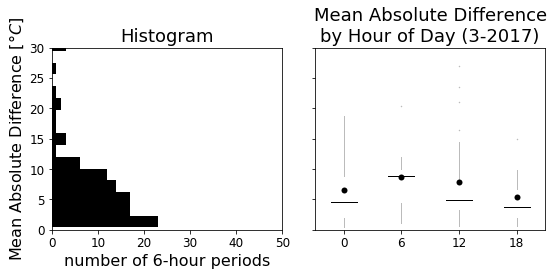

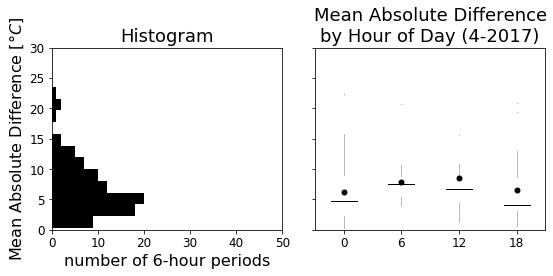

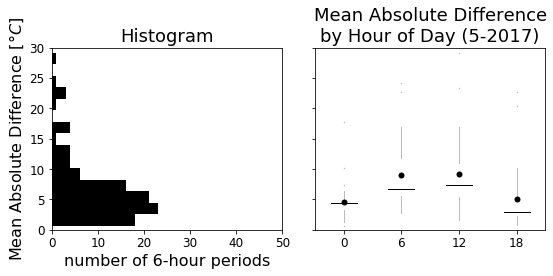

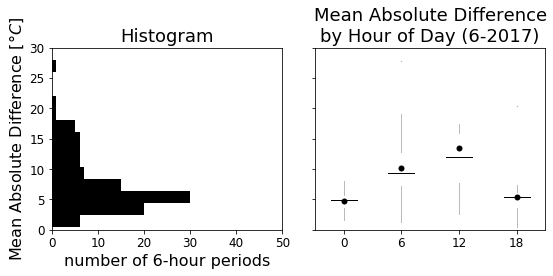

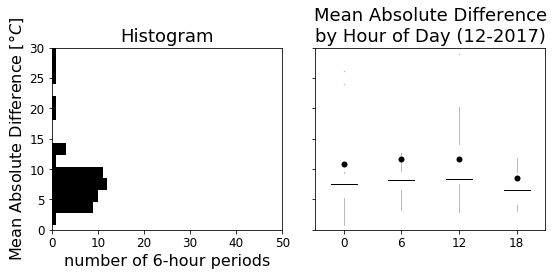

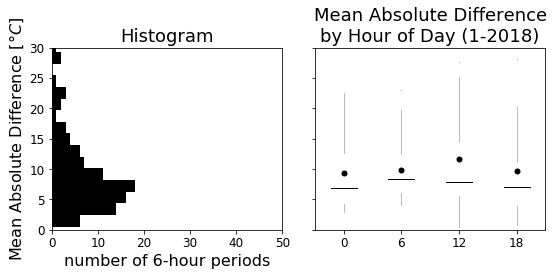

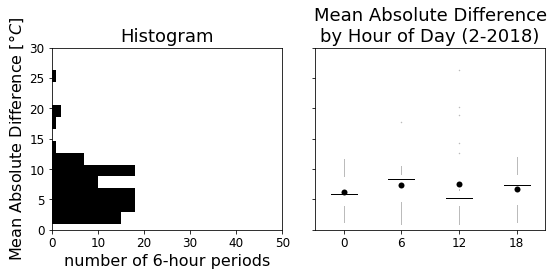

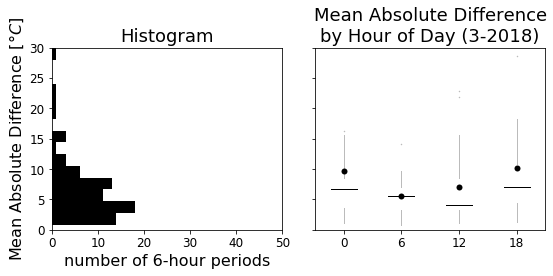

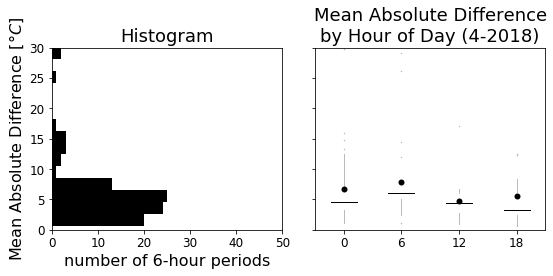

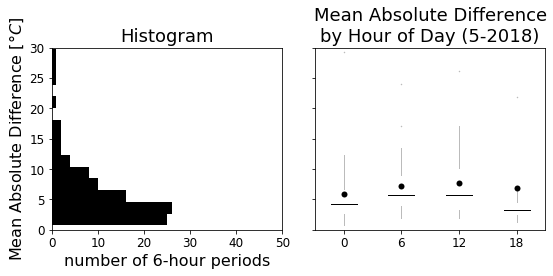

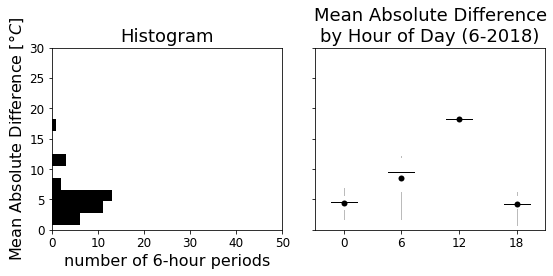

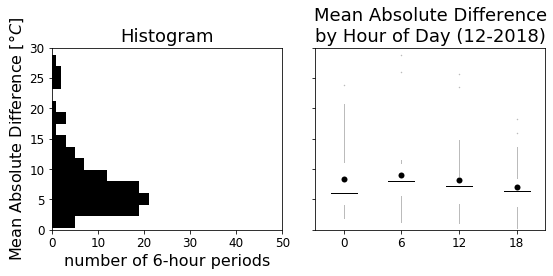

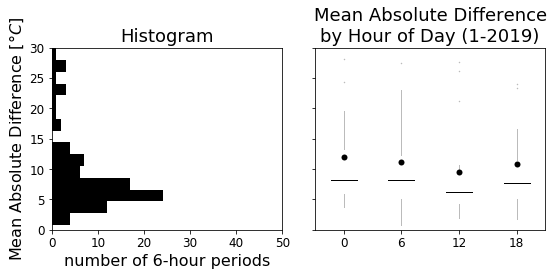

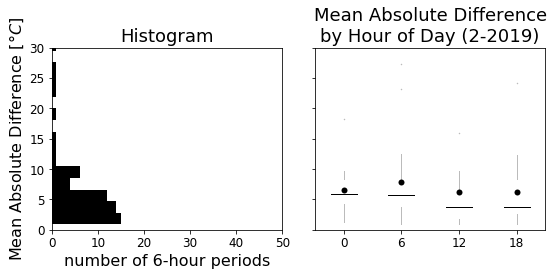

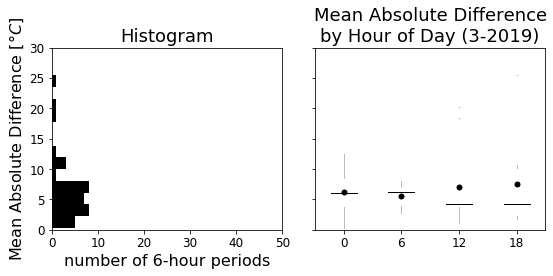

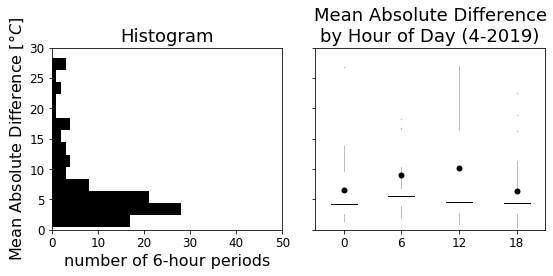

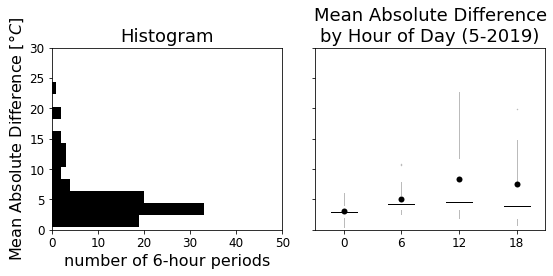

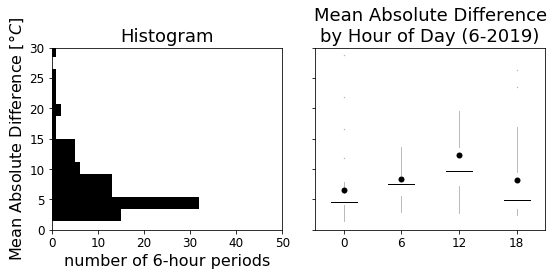

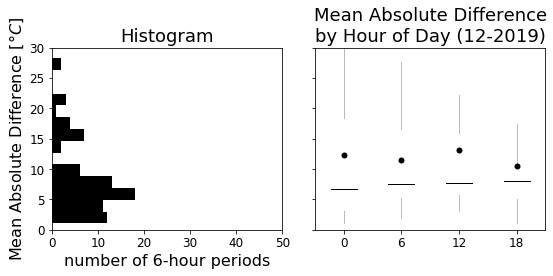

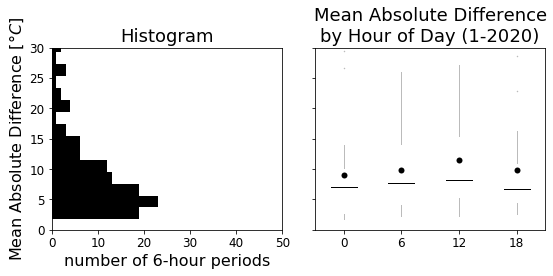

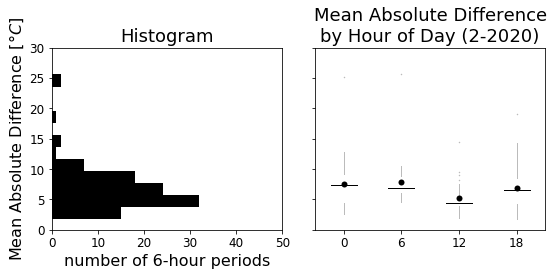

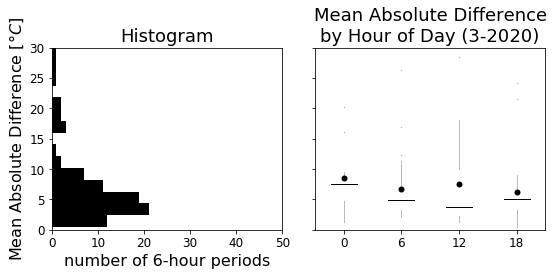

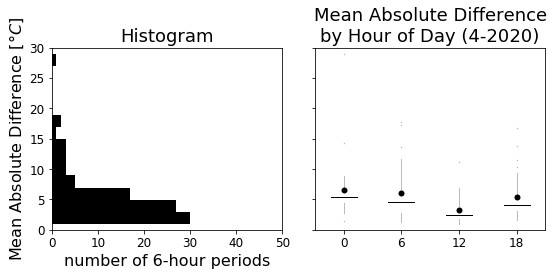

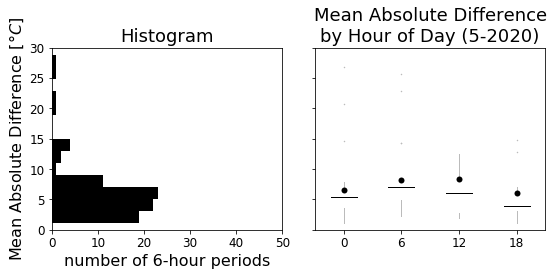

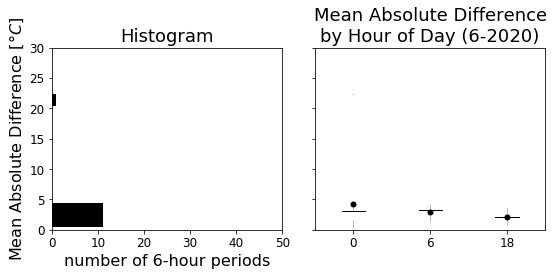

In [200]:
df = df_snow_winter_spring.copy()

for year in df.index.year.unique():
    mask = df.index.year==year
    df_n = df.loc[mask]
    
    for month in df_n.index.month.unique():
        mask = df_n.index.month==month
        df_m = df_n.loc[mask]

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

        # MAE Boxplots
        boxplot = df_m.boxplot(column='mae', by=df_m.index.hour,
                             ax=ax[1],
                             backend='matplotlib',
                             grid=False,
                             meanline=False,
                             showbox=False,
                             showcaps=False,
                             showmeans=True,
                             color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                             boxprops=boxprops,
                             whiskerprops=whiskerprops,
                             capprops=capprops,
                             flierprops=flierprops,
                             medianprops=medianprops,
                             meanprops=meanpointprops)
        ax[1].set_title('Mean Absolute Difference\nby Hour of Day ({}-{})'.format(month,year))
        plt.suptitle('') # this removes pandas' default title
        ax[1].set_xlabel('') # this removes pandas' default x labels
        # Boxplot x-axis formatting
        #plt.xticks(rotation=45, horizontalalignment='center');

        # MAE Histogram
        ax[0].hist(df_m.mae,
                   bins=int((df_m.mae.max() - df_m.mae.min())/2)+1,
                   orientation='horizontal',
                   color = '#000000',
                   ec='none',
                   lw=1)
        ax[0].set_title('Histogram')
        # Histogram x-axis formatting
        ax[0].set_xlabel('number of 6-hour periods')
        ax[0].set_xlim(0,50)

        # Format shared y-axis
        plt.ylim(0,30);
        ax[0].set_ylabel('Mean Absolute Difference [$\degree C$]')

        plt.tight_layout()
        #plt.savefig('figures/mean-absolute-errors-6-hourly-{}-{}.jpg'.format(month,year))

### Mean Bias

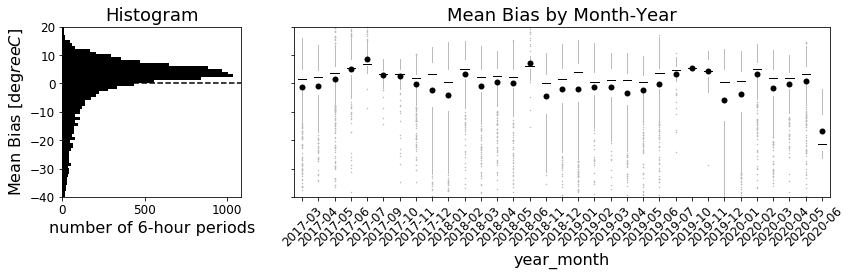

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True, gridspec_kw={'width_ratios': [1, 3]})

# Boxplots
boxplot = df.boxplot(column='mbe', by='year_month',
                     ax=ax[1],
                     backend='matplotlib',
                     grid=False,
                     meanline=False,
                     showbox=False,
                     showcaps=False,
                     showmeans=True,
                     color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                     boxprops=boxprops,
                     whiskerprops=whiskerprops,
                     capprops=capprops,
                     flierprops=flierprops,
                     medianprops=medianprops,
                     meanprops=meanpointprops)
ax[1].set_title('Mean Bias by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
plt.xticks(rotation=45, horizontalalignment='center');

# Histogram
ax[0].hist(df.mbe,
           bins=int(np.sqrt(len(df.mae))),
           orientation='horizontal',
           color = '#000000',
           ec='none',
           lw=1)
ax[0].axhline(y=0,linestyle='--',color='k')
ax[0].set_title('Histogram')
# Histogram x-axis formatting
ax[0].set_xlabel('number of 6-hour periods')

# Format shared y-axis
plt.ylim(-40,20);
ax[0].set_ylabel('Mean Bias [$\degreeC$]')

plt.tight_layout()
plt.savefig('figures/mean-biases-monthly.jpg')

---
### GOES Tb vs soil temps

In [ ]:
startdate = '2017-03-01'
enddate = '2019-12-31'

_x = cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where((cues_ds.cloud_flag==0) & (cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold))
x_label = 'CUES Soil-Surface Temp. (north) [$\degree C$]'

_y = cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold))
y_label = 'GOES Brightness Temp. [$\degree C$]'

point_color = 'tab:blue'
heatmap_cmap = 'Greys'

plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color, heatmap_cmap)      

In [ ]:
startdate = '2017-03-01'
enddate = '2019-12-31'

_x = cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where((cues_ds.cloud_flag==0) & (cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold))
x_label = 'CUES Soil-Surface Temp. (south) [$\degree C$]'

_y = cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold))
y_label = 'GOES Brightness Temp. [$\degree C$]'

point_color = 'tab:orange'
heatmap_cmap = 'Greys'

plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color, heatmap_cmap)            

In [ ]:
startdate = '2017-03-01'
enddate = '2019-12-31'

_x = cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where((cues_ds.cloud_flag==0) & (cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold))
x_label = 'CUES Soil-Surface Temp. (center) [$\degree C$]'

_y = cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold))
y_label = 'GOES Brightness Temp. [$\degree C$]'

point_color = 'tab:green'
heatmap_cmap = 'Greys'

plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color, heatmap_cmap)            